In [15]:
%matplotlib inline
from util import *
IMPATH = "/home/isaias/Pictures/checkerboardRotation/image"

rows, columns, square_width = 5, 9, 17

In [16]:
def pattern_detection(image):
    # Convert image to 1 channel
    rows, columns, square_width = 5, 9, 17
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (columns, rows), flags=cv2.CALIB_CB_FAST_CHECK)

    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Find corners with subpixel accuracy
    cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

    return corners, ret

def draw_pattern(image, corners, ret):
    # Draw corners into image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.drawChessboardCorners(image, (columns, rows), corners, ret)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

def r_rgb(image):
    return cv2.split(image)[0]


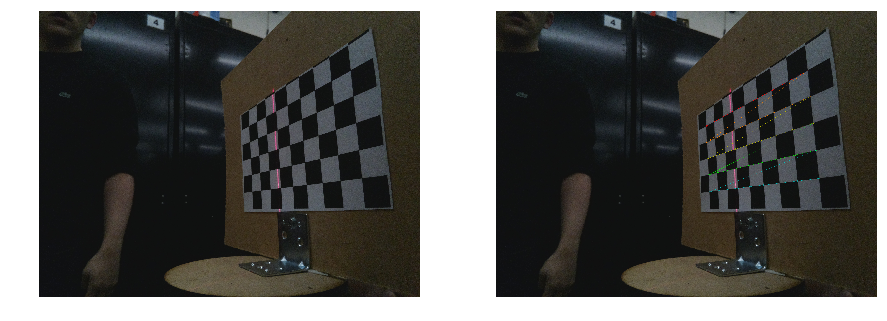

In [17]:
image = load_image(IMPATH+"1.jpg")
h, w, d = image.shape
# Pattern detection
corners, ret = pattern_detection(image)
image_corners = draw_pattern(image, corners, ret)

plot_images((image, image_corners))

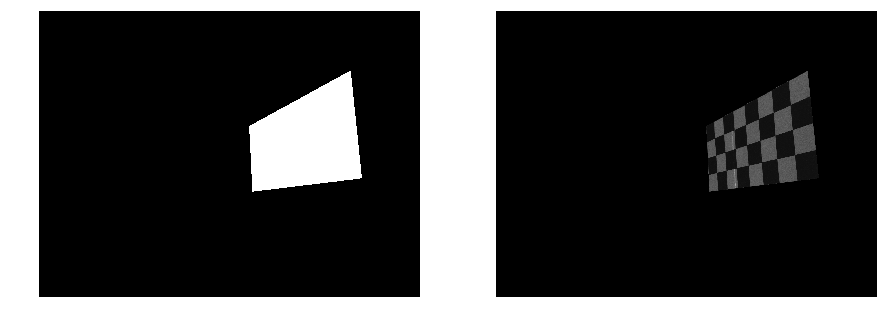

In [18]:
corners = corners.astype(np.int)
    
p1 = corners[0][0]
p2 = corners[columns - 1][0]
p3 = corners[columns * (rows - 1)][0]
p4 = corners[columns * rows - 1][0]

# Compute ROI

roi_mask = np.zeros((h, w), np.uint8)
points = np.array([p1, p2, p4, p3])
cv2.fillConvexPoly(roi_mask, points, 255)

# Apply mask

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray = cv2.bitwise_and(image_gray, roi_mask)

plot_images((roi_mask, image_gray))

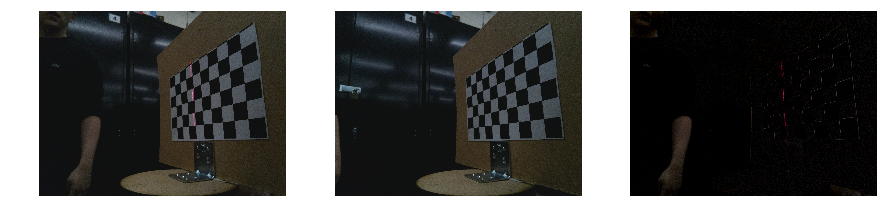

In [19]:
image = load_image(IMPATH+"1.jpg")
image_background = load_image(IMPATH+"1_laserOff.jpg")

plot_images((image,image_background, cv2.subtract(image,image_background)))

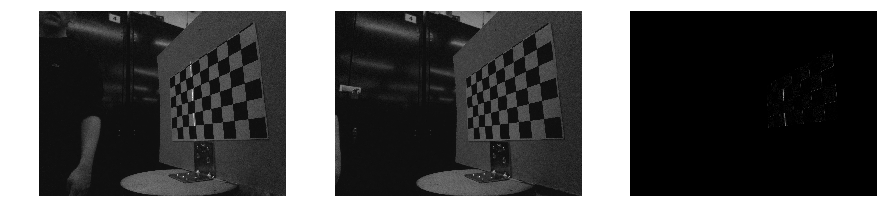

In [20]:
image_r = r_rgb(image)
image_background_r = r_rgb(image_background)
image_diff_r = cv2.subtract(image_r, image_background_r)

image_diff_r = cv2.bitwise_and(image_diff_r, roi_mask)

plot_images((image_r, image_background_r, image_diff_r))

Time: 0:00:00.006745


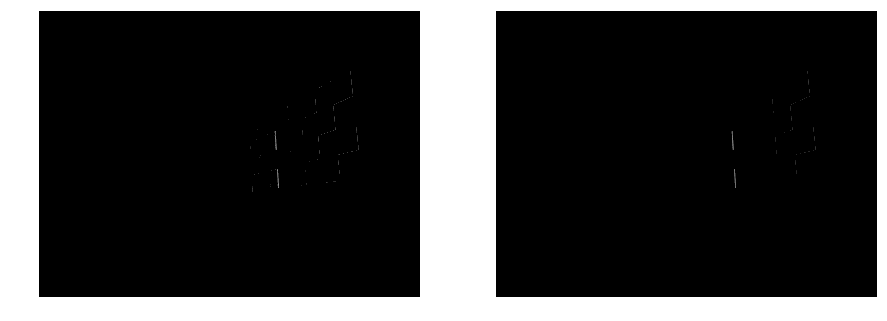

In [21]:
# Threshold image

begin()

threshold_value = 30
image_threshold = cv2.threshold(image_diff_r, threshold_value, 255, cv2.THRESH_TOZERO)[1]

# Blur image

blur_value = 5
image_blur = cv2.blur(image_threshold, (blur_value, blur_value))

image_blur_threshold = cv2.threshold(image_blur, threshold_value, 255, cv2.THRESH_TOZERO)[1]

end()

plot_images((image_threshold, image_blur_threshold))

Time: 0:00:00.010883


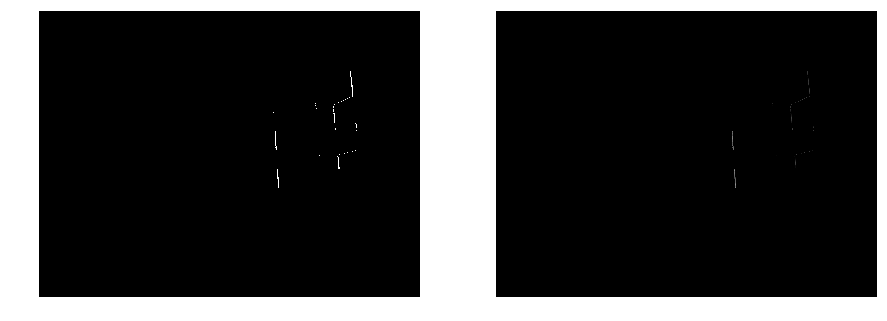

In [22]:
window = 4

begin()

peak = image_blur_threshold.argmax(axis=1)
_min = peak - window
_max = peak + window + 1
mask = np.zeros_like(image_blur_threshold)
for i in range(image_blur_threshold.shape[0]):
    mask[i, _min[i]:_max[i]] = 255

image_stripe = cv2.bitwise_and(image_diff_r, mask)

end()

plot_images((mask, image_stripe))

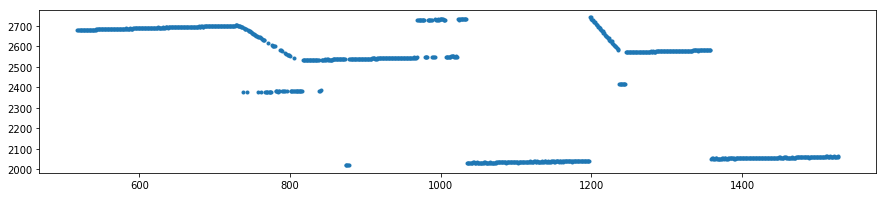

In [23]:
# Compute peak detection

s = image_stripe.sum(axis=1)
v = np.where(s > 0)[0]
peaks = image_stripe.argmax(axis=1)[v]

# Show peak detection

pylab.rcParams['figure.figsize'] = (15, 3)

plt.plot(v, peaks, '.')
plt.show()

Time: 0:00:00.047143


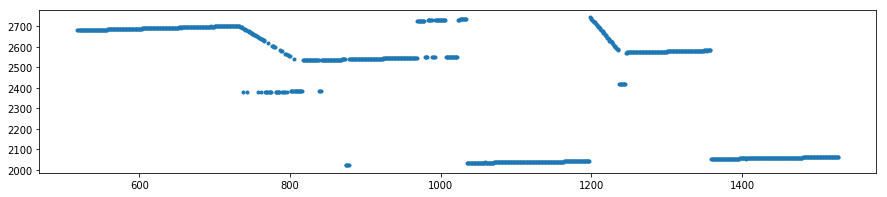

In [24]:
# Compute weight matrix

h, w = image_stripe.shape
weight_matrix = np.array((np.matrix(np.linspace(0, w - 1, w)).T * np.matrix(np.ones(h))).T)

# Compute center of mass

begin()

s = image_stripe.sum(axis=1)
v = np.where(s > 0)[0]
u = (weight_matrix * image_stripe).sum(axis=1)[v] / s[v]

end()
# Show center of mass

pylab.rcParams['figure.figsize'] = (15, 3)
    
plt.plot(v, u, '.')
plt.show()

In [25]:
from sklearn import linear_model, datasets
data = np.vstack((v.ravel(), u.ravel())).T
X = data[:,0].reshape(data.shape[0], 1)
y = data[:,1]

ransac = linear_model.RANSACRegressor(max_trials=100)
ransac.fit(X,y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = ransac.predict(line_X)


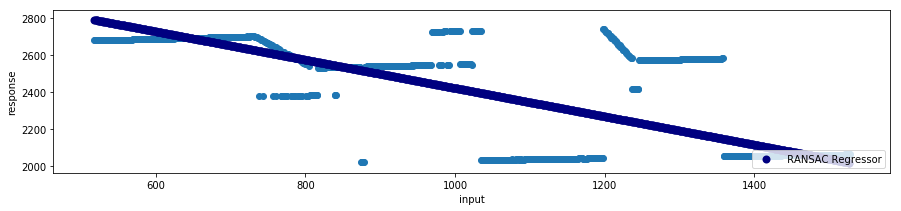

In [26]:
from matplotlib import pyplot as plt
plt.scatter(v.reshape(v.shape[0],1), u.ravel())
plt.scatter(line_X, line_y, color='navy',linewidth=2, label=' RANSAC Regressor')
plt.legend(loc='lower right')
plt.xlabel('input')
plt.ylabel('response')
plt.show()

Time: 0:00:00.009541


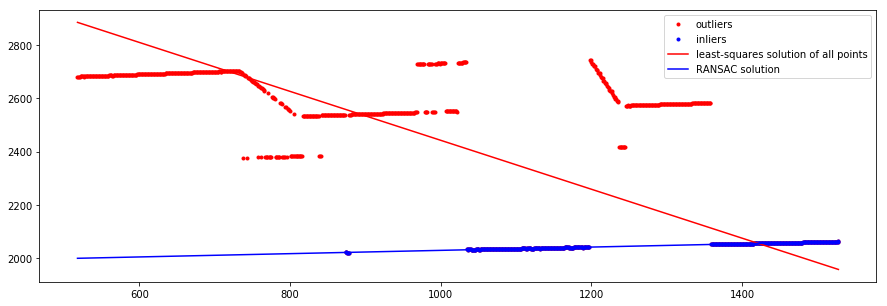

In [27]:
class LinearLeastSquares2D(object):
    '''
    2D linear least squares using the hesse normal form:
        d = x*sin(theta) + y*cos(theta)
    which allows you to have vertical lines.
    '''

    def fit(self, data):
        data_mean = data.mean(axis=0)
        x0, y0 = data_mean
        if data.shape[0] > 2:  # over determined
            u, v, w = np.linalg.svd(data - data_mean)
            vec = w[0]
            theta = math.atan2(vec[0], vec[1])
        elif data.shape[0] == 2:  # well determined
            theta = math.atan2(data[1, 0] - data[0, 0], data[1, 1] - data[0, 1])
        theta = (theta + math.pi * 5 / 2) % (2 * math.pi)
        d = x0 * math.sin(theta) + y0 * math.cos(theta)
        return d, theta

    def residuals(self, model, data):
        d, theta = model
        dfit = data[:, 0] * math.sin(theta) + data[:, 1] * math.cos(theta)
        return np.abs(d - dfit)

    def is_degenerate(self, sample):
        return False

def ransac(data, model_class, min_samples, threshold, max_trials=100):
    '''
    Fits a model to data with the RANSAC algorithm.
    :param data: numpy.ndarray
        data set to which the model is fitted, must be of shape NxD where
        N is the number of data points and D the dimensionality of the data
    :param model_class: object
        object with the following methods implemented:
         * fit(data): return the computed model
         * residuals(model, data): return residuals for each data point
         * is_degenerate(sample): return boolean value if sample choice is
            degenerate
        see LinearLeastSquares2D class for a sample implementation
    :param min_samples: int
        the minimum number of data points to fit a model
    :param threshold: int or float
        maximum distance for a data point to count as an inlier
    :param max_trials: int, optional
        maximum number of iterations for random sample selection, default 100
    :returns: tuple
        best model returned by model_class.fit, best inlier indices
    '''

    best_model = None
    best_inlier_num = 0
    best_inliers = None
    data_idx = np.arange(data.shape[0])
    for _ in range(max_trials):
        sample = data[np.random.randint(0, data.shape[0], 2)]
        if model_class.is_degenerate(sample):
            continue
        sample_model = model_class.fit(sample)
        sample_model_residua = model_class.residuals(sample_model, data)
        sample_model_inliers = data_idx[sample_model_residua < threshold]
        inlier_num = sample_model_inliers.shape[0]
        if inlier_num > best_inlier_num:
            best_inlier_num = inlier_num
            best_inliers = sample_model_inliers
    if best_inliers is not None:
        best_model = model_class.fit(data[best_inliers])
    return best_model, best_inliers


begin()

data = np.vstack((v.ravel(), u.ravel())).T
model, inliers = ransac(data, LinearLeastSquares2D(), 2, 2)

dr, thetar = model
f = (dr - v * math.sin(thetar)) / math.cos(thetar)

end()

ds, thetas = LinearLeastSquares2D().fit(data)
lr = (ds - v * math.sin(thetas)) / math.cos(thetas)

pylab.rcParams['figure.figsize'] = (15, 5)
plt.plot(data[:,0], data[:,1], '.r', label='outliers')
plt.plot(data[inliers][:,0], data[inliers][:,1], '.b', label='inliers')

plt.plot(v, lr, '-r', label='least-squares solution of all points')
plt.plot(v, f, '-b', label='RANSAC solution')

plt.legend(loc=1)
plt.show()

In [28]:
data

array([[  518.        ,  2680.55513308],
       [  519.        ,  2680.44522968],
       [  520.        ,  2680.91610738],
       ..., 
       [ 1526.        ,  2062.77927928],
       [ 1527.        ,  2063.03508772],
       [ 1528.        ,  2063.69948187]])

Total time: 0:00:00.074312


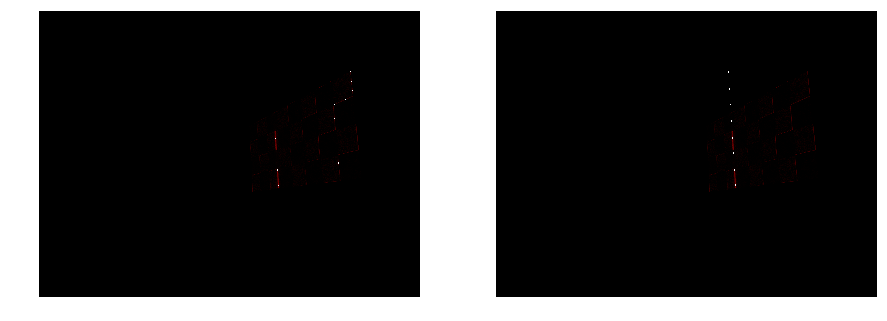

In [29]:
# Show images

image_line_cm = np.zeros_like(image_threshold)
image_line_lr = np.zeros_like(image_threshold)

image_line_cm[v, np.around(u).astype(int)] = 255
image_line_lr[v, np.around(f).astype(int)] = 255

image_cm = cv2.merge((cv2.add(image_diff_r, image_line_cm), image_line_cm, image_line_cm))
image_lr = cv2.merge((cv2.add(image_diff_r, image_line_lr), image_line_lr, image_line_lr))

total()

plot_images((image_cm, image_lr))

In [30]:
image1 = load_image(IMPATH+"1.jpg")
image2 = load_image(IMPATH+"1_laserOff.jpg")


In [31]:
image_laser = r_rgb(image1)
image_background = r_rgb(image2)

image_sub = r_rgb(cv2.subtract(image_laser, image_background))
image_sub = cv2.bitwise_and(image_sub, roi_mask)  

threshold_value = 30
image_threshold = cv2.threshold(image_diff_r, threshold_value, 255, cv2.THRESH_TOZERO)[1]

# Blur image

blur_value = 5
image_blur = cv2.blur(image_threshold, (blur_value, blur_value))

image_blur_threshold = cv2.threshold(image_blur, threshold_value, 255, cv2.THRESH_TOZERO)[1]


window = 4
peak = image_blur_threshold.argmax(axis=1)
_min = peak - window
_max = peak + window + 1
mask = np.zeros_like(image_blur_threshold)

for i in range(image_blur_threshold.shape[0]):
    mask[i, _min[i]:_max[i]] = 255

image_stripe = cv2.bitwise_and(image_sub, mask)

data = np.vstack((v.ravel(), u.ravel())).T
model, inliers = ransac(data, LinearLeastSquares2D(), 2, 2)

dr, thetar = model
f = (dr - v * math.sin(thetar)) / math.cos(thetar)

image_stripe = cv2.merge((cv2.add(image_diff_r, image_line_lr), image_line_lr, image_line_lr))

image_stripe_r = r_rgb(image_stripe)

start_px = 0
stop_px = image_stripe_r.shape[0]
sample_rate = 2
threshold = np.uint8(30)

pcl = np.zeros((3,5000))

pcl_count = 0
y = 0

for z in range(start_px, stop_px, sample_rate):
    intensity = np.amax(image_stripe_r[z,:])

    if intensity > threshold:
        x = np.argmax(image_stripe_r[z,:])
        pcl[:, pcl_count] = np.array([x,y,z])
        pcl_count += 1
pcl = pcl[:, :pcl_count]

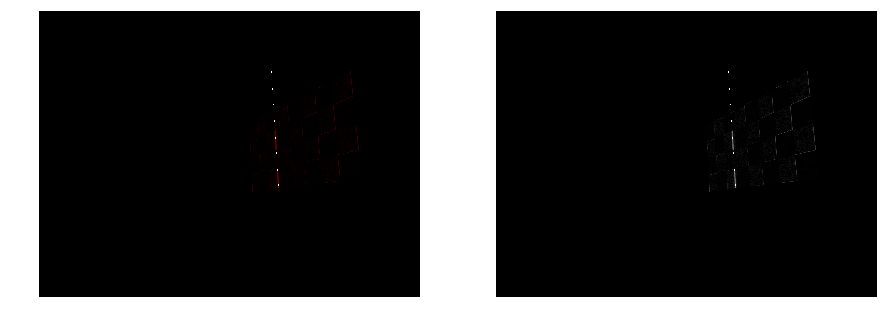

In [32]:
plot_images((image_stripe, r_rgb(image_stripe)))

In [33]:
def roi_point_detection(image1, image2):
    rows, columns, square_width = 5, 9, 17
    h, w, d = image1.shape

    corners, ret = pattern_detection(image1)
    
    corners = corners.astype(np.int)
    
    p1 = corners[0][0]
    p2 = corners[columns - 1][0]
    p3 = corners[columns * (rows - 1)][0]
    p4 = corners[columns * rows - 1][0]

    # Compute ROI

    roi_mask = np.zeros((h, w), np.uint8)
    points = np.array([p1, p2, p4, p3])
    cv2.fillConvexPoly(roi_mask, points, 255)

    image_laser = r_rgb(image1)
    image_background = r_rgb(image2)
    
    image_sub = r_rgb(cv2.subtract(image_laser, image_background))
    image_sub = cv2.bitwise_and(image_sub, roi_mask)  
    
    threshold_value = 30
    image_threshold = cv2.threshold(image_diff_r, threshold_value, 255, cv2.THRESH_TOZERO)[1]

    # Blur image

    blur_value = 5
    image_blur = cv2.blur(image_threshold, (blur_value, blur_value))

    image_blur_threshold = cv2.threshold(image_blur, threshold_value, 255, cv2.THRESH_TOZERO)[1]


    window = 4
    peak = image_blur_threshold.argmax(axis=1)
    _min = peak - window
    _max = peak + window + 1
    mask = np.zeros_like(image_blur_threshold)

    for i in range(image_blur_threshold.shape[0]):
        mask[i, _min[i]:_max[i]] = 255

    image_stripe = cv2.bitwise_and(image_sub, mask)

    data = np.vstack((v.ravel(), u.ravel())).T
    model, inliers = ransac(data, LinearLeastSquares2D(), 2, 2)

    dr, thetar = model
    f = (dr - v * math.sin(thetar)) / math.cos(thetar)

    image_stripe = cv2.merge((cv2.add(image_diff_r, image_line_lr), image_line_lr, image_line_lr))

    image_stripe_r = r_rgb(image_stripe)

    start_px = 0
    stop_px = image_stripe_r.shape[0]
    sample_rate = 2
    threshold = np.uint8(30)

    pcl = np.zeros((3,5000))

    pcl_count = 0
    y = 0

    for z in range(start_px, stop_px, sample_rate):
        intensity = np.amax(image_stripe_r[z,:])

        if intensity > threshold:
            x = np.argmax(image_stripe_r[z,:])
            pcl[:, pcl_count] = np.array([x,y,z])
            pcl_count += 1
    return pcl[:, :pcl_count]

In [37]:
from glob import glob
IMPATH = "/home/isaias/Pictures/checkerboardRotation/image"

images = glob(IMPATH+"*")
for i in range(1, round(len(images) /2) + 1):
    imfile1 = IMPATH + str(i) + ".jpg"
    imfile2 = IMPATH + str(i) + "_laserOff.jpg"
    
    image_laser = load_image(imfile1)
    image_background = load_image(imfile2)
    # Compute object points
    
    print(imfile1)
    print(imfile2)
    
    points = roi_point_detection(image_laser, image_background)

/home/isaias/Pictures/checkerboardRotation/image1.jpg
/home/isaias/Pictures/checkerboardRotation/image1_laserOff.jpg
/home/isaias/Pictures/checkerboardRotation/image2.jpg
/home/isaias/Pictures/checkerboardRotation/image2_laserOff.jpg
/home/isaias/Pictures/checkerboardRotation/image3.jpg
/home/isaias/Pictures/checkerboardRotation/image3_laserOff.jpg
/home/isaias/Pictures/checkerboardRotation/image4.jpg
/home/isaias/Pictures/checkerboardRotation/image4_laserOff.jpg
/home/isaias/Pictures/checkerboardRotation/image5.jpg
/home/isaias/Pictures/checkerboardRotation/image5_laserOff.jpg
/home/isaias/Pictures/checkerboardRotation/image6.jpg
/home/isaias/Pictures/checkerboardRotation/image6_laserOff.jpg
/home/isaias/Pictures/checkerboardRotation/image7.jpg
/home/isaias/Pictures/checkerboardRotation/image7_laserOff.jpg
/home/isaias/Pictures/checkerboardRotation/image8.jpg
/home/isaias/Pictures/checkerboardRotation/image8_laserOff.jpg
/home/isaias/Pictures/checkerboardRotation/image9.jpg
/home/isai

In [13]:
image_laser = load_image(IMPATH + str(i) + ".jpg")
image_background = load_image(IMPATH + str(i) + "_laserOff.jpg")
# Compute object points

#    points = roi_point_detection(image_laser, image_background)

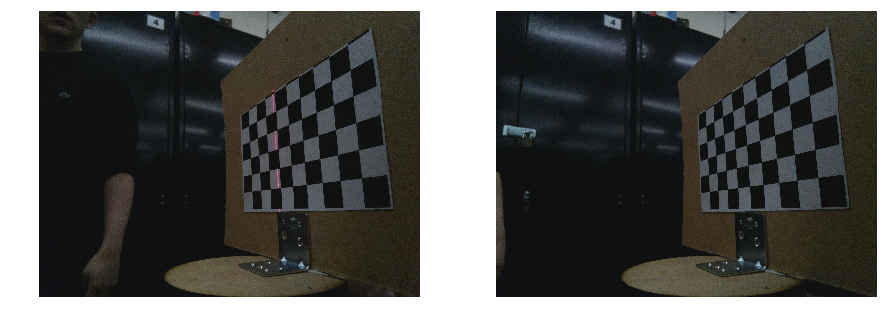

In [14]:
plot_images((image_laser,image_background))

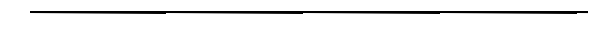

In [121]:
plot_image(pcl)

In [35]:
points

array([[ 2682.,  2000.,  2000., ...,  1839.,  1838.,  1838.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [  516.,   518.,   520., ...,  1552.,  1554.,  1556.]])

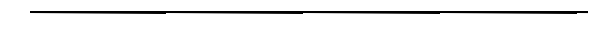

In [36]:
plot_image(points)